# How to Detect Heteroskedasticity in Time Series
Dec 21st 2022

In [19]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from pmdarima.datasets import load_airpassengers
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']
FORMULA = 'value ~ time'

class Heteroskedasticity:
    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        """
        Testing for heteroskedasticity
        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'
        :return: p-value as a float.
        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        """
        assert test in TEST_NAMES, 'Unknown test'
        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1
        olsr = ols(FORMULA, series).fit()
        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(olsr.resid, olsr.model.exog)
        return p_value
    @classmethod
    def run_all_tests(cls, series: pd.Series):
        test_results = {k: cls.het_tests(series, k) for k in TEST_NAMES}
        return test_results

In [3]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (13, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

## 1) Input data

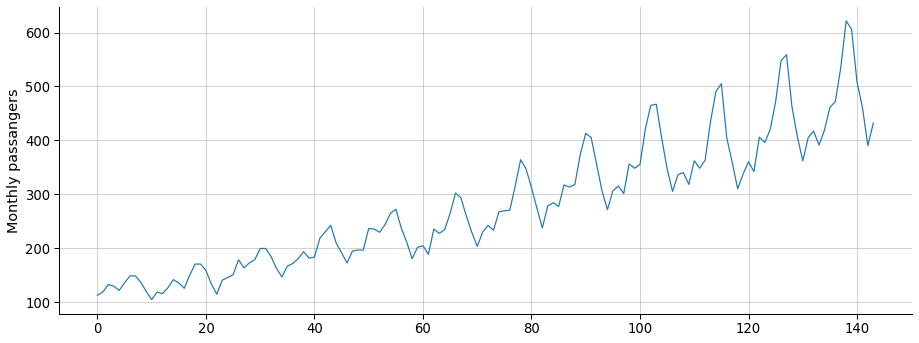

In [4]:
series = load_airpassengers(True)
series.plot()
plt.ylabel("Monthly passangers")
plt.grid(alpha= 0.7)
plt.tight_layout()

## 2) Statistical tests
* [White test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html#statsmodels.stats.diagnostic.het_white)
* [Breusch-Pagan test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)
* [Goldfeld–Quandt test](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html#statsmodels.stats.diagnostic.het_goldfeldquandt)

### Interpretation of statistical tests
The main input to these tests is the residuals of a regression model (e.g. ordinary least squares).
*  `null hypothesis` is that the residuals are distributed with equal variance, i.e. the time series is homoskedastic.
* `alternative hypothesis` the time series is heteroskedastic.

In [5]:
test_results = Heteroskedasticity.run_all_tests(series)
test_results

{'White': 4.345754466128593e-07,
 'Breusch-Pagan': 4.559001856883289e-07,
 'Goldfeld-Quandt': 8.812950329262079e-13}

## 3) Transform the data
A common remedy to heteroskedasticity in time series is to transform the data. Taking the `logarithm` of the time series is helpful to stabilize its variability.

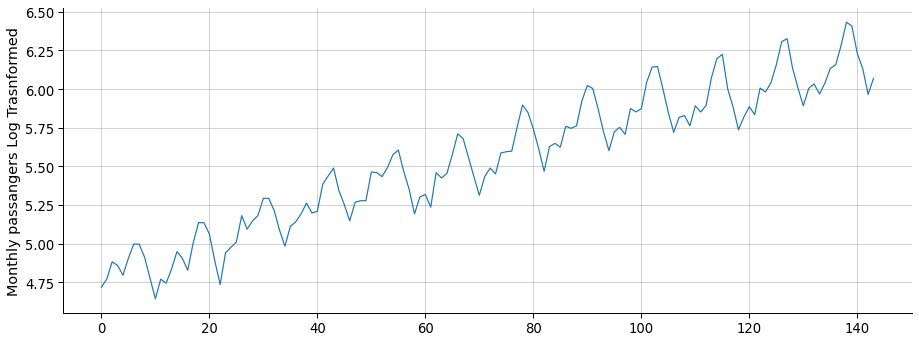

In [14]:
np.log(series).plot()
plt.ylabel("Monthly passangers Log Trasnformed")
plt.grid(alpha= 0.7)
plt.tight_layout()

In [15]:
test_results = Heteroskedasticity.run_all_tests(np.log(series))
test_results

{'White': 0.10018100617380607,
 'Breusch-Pagan': 0.03292678759563159,
 'Goldfeld-Quandt': 0.18331567974365376}

## 4) Forecast with transformed data

In [24]:
series = load_airpassengers(True)

# leaving the last 12 points for testing
train, test = train_test_split(series, test_size=12, shuffle=False)

# stabilizing the variance in the train
log_train = np.log(train)

# building an arima model, m is the seasonal period (monthly)
mod = auto_arima(log_train, seasonal=True, m=12)

In [28]:
# getting the log forecasts
log_forecasts = mod.predict(12)

# reverting the forecasts
forecasts = np.exp(log_forecasts)

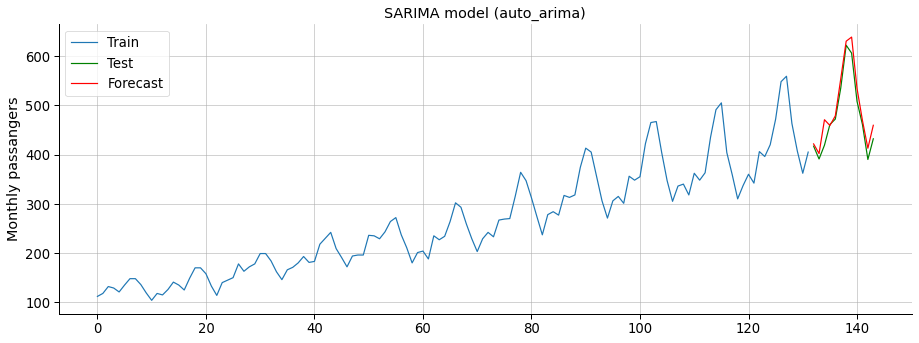

In [62]:
train.plot(label= "Train")
test.plot(color= "green", label= "Test")
forecasts.plot(color= "red", label= "Forecast")
plt.grid(alpha= 0.7)
plt.legend(loc='best')
plt.title("SARIMA model (auto_arima)")
plt.ylabel("Monthly passangers")
plt.tight_layout()